In [50]:
import tensorflow as tf
print(tf.__version__)
"""ENSURE YOUR USING TENSORFLOW VERSION 2.17.0
"""


2.17.0


'ENSURE YOUR USING TENSORFLOW VERSION 2.17.0\n'

### STEP 1: LOAD BELOW LIBRARIES

In [92]:
"""
MANDATORY LIBRARIES***

tensorflow 
scikit-learn
yfinance
pandas

"""

'\nMANDATORY LIBRARIES***\n\ntensorflow \nscikit-learn\nyfinance\npandas\n\n'

In [107]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
"""
USE ABOVE TO SUPPRESS UNWANTED WARNINGS
"""

'\nUSE ABOVE TO SUPPRESS UNWANTED WARNINGS\n'

### STEP 2. Loading the Trained Model 

In [108]:
model = load_model('lstm_btc_V1.h5')
"""
Loads the pre-trained LSTM model that will be used to predict future
Bitcoin prices. Without this, you can't make predictions.
"""

"\nLoads the pre-trained LSTM model that will be used to predict future\nBitcoin prices. Without this, you can't make predictions.\n"

### STEP 3. Fetching Bitcoin Data

In [95]:

"""
Fetches the last 60 days of Bitcoin price data from Yahoo Finance. This data is necessary for making the predictions.
data[['Close']]: Only the closing prices are used, which are typically what you want to predict.
"""

"""LOAD AND DISPLAY THIS DATA IN HOMEPAGE AS SOON AS PROGRAM RUNS"""

'LOAD AND DISPLAY THIS DATA IN HOMEPAGE AS SOON AS PROGRAM RUNS'

In [109]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the ticker symbol for Bitcoin
ticker = 'BTC-USD'

# Calculate the date 60 days before today
end_date = datetime.now()
start_date = end_date - timedelta(days=60)

# Download Bitcoin data
data = yf.download(ticker, start=start_date, end=end_date)

# Select and rename columns if necessary
data = data[['Close']]
data.rename(columns={'Close': 'Close'}, inplace=True)

[*********************100%%**********************]  1 of 1 completed


###  STEP 4. Scaling the Data

In [97]:
"""
Scaling: Transforms the data into a range between 0 and 1, which is crucial for the model to make accurate predictions. 
The model was trained on scaled data, so the input must be scaled similarly.
"""

'\nScaling: Transforms the data into a range between 0 and 1, which is crucial for the model to make accurate predictions. \nThe model was trained on scaled data, so the input must be scaled similarly.\n'

In [111]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Print length of scaled data
print("Length of scaled_data:", len(scaled_data))


Length of scaled_data: 60


### STEP 5. CREATING SEQUENCES

In [99]:
"""
Sequence Creation: The model predicts based on a sequence of previous prices. This function splits the data into 
sequences of a specified length (e.g., 60 days of prices to predict the next day’s price).
"""

'\nSequence Creation: The model predicts based on a sequence of previous prices. This function splits the data into \nsequences of a specified length (e.g., 60 days of prices to predict the next day’s price).\n'

In [112]:
# Define a function to create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Define sequence length (shorten to fit available data)
sequence_length = min(60, len(scaled_data) - 1)  # Shorten to 30 if not enough data for 60

# Check if data length is sufficient
if len(scaled_data) > sequence_length:
    # Create sequences
    X, y = create_sequences(scaled_data, sequence_length)
    
    # Print shapes to debug
    print("Shape of X before reshaping:", X.shape)
    print("Shape of y:", y.shape)
    
    # Reshape X if necessary
    if len(X.shape) == 2:
        X = X.reshape((X.shape[0], X.shape[1], 1))

    # Display shapes of X and y
    print("Shape of X after reshaping:", X.shape)
    print("Shape of y:", y.shape)
else:
    print(f"Not enough data to create sequences. Length of data: {len(scaled_data)}, Sequence length: {sequence_length}")

Shape of X before reshaping: (1, 59, 1)
Shape of y: (1, 1)
Shape of X after reshaping: (1, 59, 1)
Shape of y: (1, 1)


### STEP 6. Preparing Data for Prediction

In [113]:
"""
Preparing the last sequence of data: This data is the input to the model for predicting future prices. 
It's reshaped to match the input shape expected by the model.
"""

"\nPreparing the last sequence of data: This data is the input to the model for predicting future prices. \nIt's reshaped to match the input shape expected by the model.\n"

In [114]:
# Prepare the latest data for prediction
if len(scaled_data) >= sequence_length:
    last_data = scaled_data[-sequence_length:]
    last_data = last_data.reshape((1, sequence_length, 1))  # Reshape for model input
else:
    raise ValueError("Not enough data for prediction. Please collect more data.")


### STEP 7. Forecasting Future Prices

In [115]:
"""
forecast_future_prices Function: This is where the magic happens. The model uses the most recent data to predict future prices. 
The function:
Predicts the price for the next day.
Adds this prediction to the list and shifts the input data to use this prediction for the next day’s prediction.
Continues this for as many days as requested.
"""

'\nforecast_future_prices Function: This is where the magic happens. The model uses the most recent data to predict future prices. \nThe function:\nPredicts the price for the next day.\nAdds this prediction to the list and shifts the input data to use this prediction for the next day’s prediction.\nContinues this for as many days as requested.\n'

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to forecast future prices
def forecast_future_prices(model, last_data, n_days, scaler, last_date):
    predictions = []
    dates = []
    
    # Initialize the current date to the last date in the data
    current_date = last_date
    
    for _ in range(n_days):
        # Predict the next value
        pred_scaled = model.predict(last_data)
        pred = scaler.inverse_transform(pred_scaled).flatten()
        
        # Append the prediction and date
        predictions.append(pred[0])
        current_date = current_date + pd.Timedelta(days=1)
        dates.append(current_date.date())
        
        # Update last_data for the next prediction
        last_data = np.roll(last_data, shift=-1, axis=1)
        last_data[0, -1, 0] = pred_scaled[0, 0]
    
    return dates, predictions


### STEP 8.Handling User Input and Displaying the Forecast

In [117]:
"""
 After making predictions, the results are displayed in a table and a line chart, 
 showing how the predicted price changes over time. IF POSSIBLE MAKE IT DYNAMIC EG CHART SHOULD REACTLIVE TO SLIDER
"""

'\n After making predictions, the results are displayed in a table and a line chart, \n showing how the predicted price changes over time. IF POSSIBLE MAKE IT DYNAMIC EG CHART SHOULD REACTLIVE TO SLIDER\n'

Forecasting for 21 days.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
          Date  Predicted Price
0   2024-08-25     62146.238281
1   2024-08-26     62814.707031
2   2024-08-27     63455.863281
3   2024-08-28     64066.683594
4   2024-08-29   

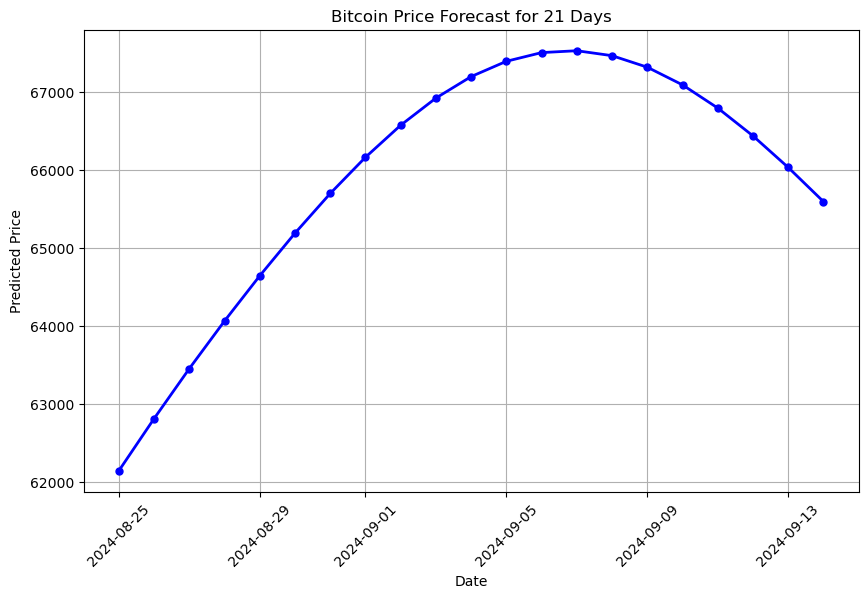

In [123]:

# Function to be called on button click
def on_button_click(b):
    clear_output(wait=True)
    n_days = slider.value
    print(f"Forecasting for {n_days} days.")
    
    # Define 'last_date' as the last date of your data
    last_date = pd.Timestamp.today()  # Example; replace with the actual last date from your dataset
    
    # Assuming 'last_data' and 'scaler' are already defined
    dates, predictions = forecast_future_prices(model, last_data, n_days, scaler, last_date)
    
    # Display the forecast dates and predictions
    forecast_df = pd.DataFrame({
        'Date': dates,
        'Predicted Price': predictions
    })
    print(forecast_df)
    
    # Plot the predictions
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_df['Date'], forecast_df['Predicted Price'], marker='o', color='blue', linestyle='-', linewidth=2, markersize=5)
    plt.title(f'Bitcoin Price Forecast for {n_days} Days')
    plt.xlabel('Date')
    plt.ylabel('Predicted Price')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Slider for user to select the number of days to forecast
slider = widgets.IntSlider(
    value=7,
    min=7,
    max=30,
    step=7,
    description='Days to Forecast:',
    style={'description_width': 'initial'}
)
display(slider)

# Button to execute the forecast
button = widgets.Button(description="Forecast", button_style='info')
button.on_click(on_button_click)
display(button)